## Problem 1(a)

### STEP 1: MNIST Dataset + Seed (Reproducibility) Setup

In this step we only do the required dataset setup.

Use MNIST (60,000 train / 10,000 test)

Each image is grayscale 1×28×28

Normalize pixels to [0, 1]

Use mini-batches (batch size 64 or 128)

Set a random seed and print/report it

Print one mini-batch info to confirm shapes & ranges

In [2]:
# ==========================================
# Problem 1(a) - STEP 1: MNIST + Seed Setup
# ==========================================

import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1) Set and report a random seed
SEED = 42
print(f"[INFO] Random Seed = {SEED}")

# 2) Reproducibility: set seeds for python, numpy, torch
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# (Optional but good practice if you later use GPU)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 3) Transform:
# ToTensor() converts (H,W) uint8 [0..255] -> float tensor [0..1] with shape (1,28,28)
transform = transforms.ToTensor()

# 4) Load MNIST (downloads if not already present)
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print(f"[INFO] Train samples = {len(train_ds)} | Test samples = {len(test_ds)}")

# 5) DataLoaders (mini-batches)
BATCH_SIZE = 128  # choose 64 or 128 (recommended)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print(f"[INFO] Batch size = {BATCH_SIZE}")

# 6) Sanity check: inspect one batch
x, y = next(iter(train_loader))

print("[SANITY] x.shape =", x.shape)  # expected: (B, 1, 28, 28)
print("[SANITY] y.shape =", y.shape)  # expected: (B,)
print("[SANITY] x.min/max =", float(x.min()), float(x.max()))  # expected: 0.0 to 1.0
print("[SANITY] y sample =", y[:10].tolist())


[INFO] Random Seed = 42


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.74MB/s]


[INFO] Train samples = 60000 | Test samples = 10000
[INFO] Batch size = 128
[SANITY] x.shape = torch.Size([128, 1, 28, 28])
[SANITY] y.shape = torch.Size([128])
[SANITY] x.min/max = 0.0 1.0
[SANITY] y sample = [1, 2, 8, 5, 2, 6, 9, 9, 9, 4]


### STEP 2: Define the 3-layer MLP (Feedforward Network)

Now we build the model required:

Input: MNIST image 1×28×28 → flatten to 784

A 3-layer MLP (i.e., 3 fully-connected layers)

Output: 10 classes (digits 0–9)

We’ll keep it clean and flexible:

fc1 -> ReLU -> fc2 -> ReLU -> fc3

fc3 outputs logits (no softmax here, because loss will handle it)

In [3]:
# ==========================================
# Problem 1(a) - STEP 2: Define 3-layer MLP
# ==========================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP3(nn.Module):
    """
    3-layer MLP for MNIST classification:
      - Flatten 28x28 -> 784
      - FC -> ReLU -> FC -> ReLU -> FC (logits for 10 classes)
    """
    def __init__(self, input_dim=28*28, hidden1=256, hidden2=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)   # Layer 1
        self.fc2 = nn.Linear(hidden1, hidden2)     # Layer 2
        self.fc3 = nn.Linear(hidden2, num_classes) # Layer 3 (output logits)

    def forward(self, x):
        # x comes in as (B, 1, 28, 28) -> flatten to (B, 784)
        x = x.view(x.size(0), -1)

        # Forward pass through the 3 FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)   # logits shape: (B, 10)

        return logits

# Create the model
model = MLP3()

# Quick sanity check: run one batch through and print output shape
x_batch, y_batch = next(iter(train_loader))
out = model(x_batch)
print("[SANITY] model output shape:", out.shape)  # expected: (128, 10)
print("[SANITY] first row (logits) sample:", out[0].detach().cpu()[:5])


[SANITY] model output shape: torch.Size([128, 10])
[SANITY] first row (logits) sample: tensor([ 0.0742, -0.0244,  0.0272, -0.0700, -0.0260])


### STEP 3: Loss #1 = Cross-Entropy (standard classification loss)

Now we implement the first required loss:

Cross-Entropy Loss for 10-class classification

Works with logits (raw outputs from the model), so no softmax needed in the model

We’ll do a quick forward pass and print the loss value (should be a positive float)

In [4]:
# ==========================================
# Problem 1(a) - STEP 3: Cross-Entropy Loss
# ==========================================

import torch
import torch.nn as nn

# 1) Define the standard cross-entropy loss
ce_loss_fn = nn.CrossEntropyLoss()

# 2) Take one batch and compute CE loss
x_batch, y_batch = next(iter(train_loader))

logits = model(x_batch)              # shape: (B, 10)
loss_ce = ce_loss_fn(logits, y_batch)  # scalar loss

print("[SANITY] CE loss value:", float(loss_ce.item()))


[SANITY] CE loss value: 2.305025100708008


### STEP 4: Custom Loss A = Sigmoid + MSE (L2) Loss

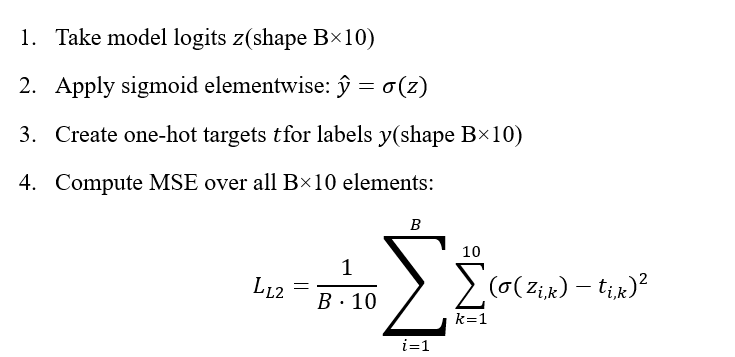

So we’ll implement

In [5]:
# ==============================================
# Problem 1(a) - STEP 4: Loss A (Sigmoid + MSE)
# ==============================================

import torch
import torch.nn.functional as F

def one_hot_labels(y, num_classes=10):
    """
    Convert integer labels (B,) to one-hot targets (B, num_classes).
    Example: y=3 -> [0,0,0,1,0,0,0,0,0,0]
    """
    return F.one_hot(y, num_classes=num_classes).float()

def loss_sigmoid_mse(logits, y, num_classes=10):
    """
    Implements Loss A exactly as in the homework:
      - sigmoid(logits) -> y_hat
      - one-hot(y) -> targets
      - MSE averaged over B*10 elements
    """
    y_hat = torch.sigmoid(logits)                 # (B,10)
    targets = one_hot_labels(y, num_classes)      # (B,10)
    mse = (y_hat - targets) ** 2                  # (B,10)
    return mse.mean()                             # scalar = sum/(B*10)

# ---- sanity check on one batch ----
x_batch, y_batch = next(iter(train_loader))
logits = model(x_batch)

loss_a = loss_sigmoid_mse(logits, y_batch)
print("[SANITY] Loss A (Sigmoid+MSE) value:", float(loss_a.item()))
print("[SANITY] y_hat range:", float(torch.sigmoid(logits).min()), float(torch.sigmoid(logits).max()))


[SANITY] Loss A (Sigmoid+MSE) value: 0.24972756206989288
[SANITY] y_hat range: 0.4642525911331177 0.5279279351234436


/tmp/ipython-input-1482691701.py:33: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("[SANITY] y_hat range:", float(torch.sigmoid(logits).min()), float(torch.sigmoid(logits).max()))


### STEP 5: Custom Loss B = Stable Softmax + Cross-Entropy

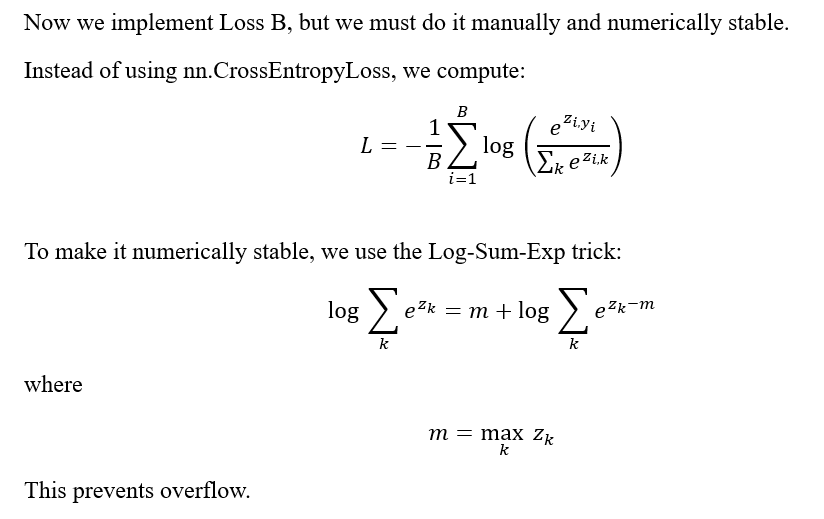

In [6]:
# =====================================================
# Problem 1(a) - STEP 5: Loss B (Stable Softmax + CE)
# =====================================================

import torch

def loss_stable_softmax_ce(logits, y):
    """
    Implements Cross-Entropy manually using the log-sum-exp trick.

    logits: (B,10)
    y:      (B,)
    """

    # 1) Get max logit per sample for numerical stability
    max_logits, _ = torch.max(logits, dim=1, keepdim=True)  # (B,1)

    # 2) Shift logits
    shifted_logits = logits - max_logits  # (B,10)

    # 3) Compute log-sum-exp
    log_sum_exp = max_logits.squeeze() + torch.log(
        torch.sum(torch.exp(shifted_logits), dim=1)
    )  # (B,)

    # 4) Get correct class logits
    correct_class_logits = logits[torch.arange(logits.size(0)), y]  # (B,)

    # 5) Compute negative log-likelihood
    loss = -(correct_class_logits - log_sum_exp)

    # 6) Average over batch
    return loss.mean()


# ---- sanity check ----
x_batch, y_batch = next(iter(train_loader))
logits = model(x_batch)

loss_b = loss_stable_softmax_ce(logits, y_batch)

print("[SANITY] Loss B (Stable Softmax CE):", float(loss_b.item()))


[SANITY] Loss B (Stable Softmax CE): 2.301959991455078


### STEP 6: Training loop using Loss A (Sigmoid + MSE), 3 epochs


Now we train the same MLP using Loss A:

Optimizer: Adam

Epochs: 3

For each epoch, compute:

average train loss

average train accuracy

test accuracy at the end of epoch

Accuracy is computed from logits argmax (same as standard classification).

In [7]:
# ==========================================================
# Problem 1(a) - STEP 6: Train the MLP with Loss A (3 epochs)
# ==========================================================

import torch
import torch.optim as optim

# 1) Device setup (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] device:", device)

# 2) Re-create a fresh model (important: training must start from scratch)
model_a = MLP3().to(device)

# 3) Optimizer
optimizer = optim.Adam(model_a.parameters(), lr=1e-3)

# 4) Training settings
EPOCHS = 3

def accuracy_from_logits(logits, y):
    """Compute classification accuracy from logits."""
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model_a.train()
    train_loss_sum = 0.0
    train_acc_sum = 0.0
    n_batches = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model_a(x)

        # Loss A
        loss = loss_sigmoid_mse(logits, y)

        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_acc_sum += accuracy_from_logits(logits, y)
        n_batches += 1

    avg_train_loss = train_loss_sum / n_batches
    avg_train_acc = train_acc_sum / n_batches

    # ---- TEST ----
    model_a.eval()
    test_acc_sum = 0.0
    test_batches = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model_a(x)
            test_acc_sum += accuracy_from_logits(logits, y)
            test_batches += 1

    avg_test_acc = test_acc_sum / test_batches

    print(f"[EPOCH {epoch}] train_loss={avg_train_loss:.4f} | train_acc={avg_train_acc*100:.2f}% | test_acc={avg_test_acc*100:.2f}%")


[INFO] device: cpu
[EPOCH 1] train_loss=0.0337 | train_acc=76.86% | test_acc=93.90%
[EPOCH 2] train_loss=0.0088 | train_acc=94.79% | test_acc=95.67%
[EPOCH 3] train_loss=0.0062 | train_acc=96.40% | test_acc=96.75%


STEP 7: Train the MLP with Loss B (Stable Softmax Cross-Entropy), 3 epochs

Now we train the same architecture from scratch but using Loss B (your stable softmax CE):

Fresh model model_b (so results are fair)

Optimizer: Adam

Epochs: 3

Print per epoch:

average train loss

average train accuracy

average test accuracy

In [8]:
# ==========================================================
# Problem 1(a) - STEP 7: Train the MLP with Loss B (3 epochs)
# ==========================================================

import torch
import torch.optim as optim

# 1) Device (reuse the same as before)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] device:", device)

# 2) Fresh model (start from scratch)
model_b = MLP3().to(device)

# 3) Optimizer
optimizer = optim.Adam(model_b.parameters(), lr=1e-3)

# 4) Training settings
EPOCHS = 3

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model_b.train()
    train_loss_sum = 0.0
    train_acc_sum = 0.0
    n_batches = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model_b(x)

        # Loss B (stable softmax CE)
        loss = loss_stable_softmax_ce(logits, y)

        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        train_acc_sum += accuracy_from_logits(logits, y)
        n_batches += 1

    avg_train_loss = train_loss_sum / n_batches
    avg_train_acc = train_acc_sum / n_batches

    # ---- TEST ----
    model_b.eval()
    test_acc_sum = 0.0
    test_batches = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model_b(x)
            test_acc_sum += accuracy_from_logits(logits, y)
            test_batches += 1

    avg_test_acc = test_acc_sum / test_batches

    print(f"[EPOCH {epoch}] train_loss={avg_train_loss:.4f} | train_acc={avg_train_acc*100:.2f}% | test_acc={avg_test_acc*100:.2f}%")


[INFO] device: cpu
[EPOCH 1] train_loss=0.3447 | train_acc=90.20% | test_acc=95.51%
[EPOCH 2] train_loss=0.1308 | train_acc=96.06% | test_acc=96.77%
[EPOCH 3] train_loss=0.0869 | train_acc=97.29% | test_acc=97.22%


### STEP 8: Compare Loss A vs Loss B (results + short explanation)

Now we summarize what happened when training the same 3-layer MLP on MNIST with:

Loss A: Sigmoid + MSE (L2)

Loss B: Stable Softmax + Cross-Entropy

We’ll compare train/test accuracy after 3 epochs and explain why one usually performs better.

Your results (from your outputs)

Loss A (Sigmoid + MSE):

Epoch 1: test 93.90%

Epoch 2: test 95.67%

Epoch 3: test 96.75%

Loss B (Stable Softmax CE):

Epoch 1: test 95.51%

Epoch 2: test 96.77%

Epoch 3: test 97.22%

### Comparison Table

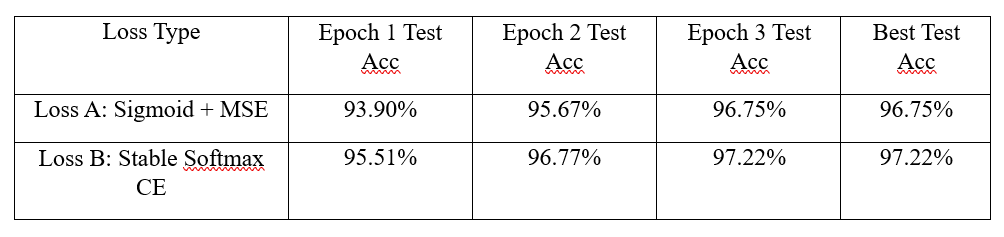

### STEP 9: Add He (Kaiming) / Xavier Initialization

Default nn.Linear initialization can work, but the homework explicitly requires He (Kaiming) or Xavier (Glorot).

Because your hidden layers use ReLU, the best match is:

He/Kaiming init for fc1 and fc2 (ReLU layers)

For the final layer fc3, Xavier is also okay, but Kaiming works fine too.
We’ll do a clean, standard approach:

kaiming_normal_ for weights

biases = 0

We’ll also print a quick sanity check (mean/std) to prove init happened.

In [9]:
# ==========================================================
# Problem 1(a) - STEP 9: Proper Weight Initialization (He)
# ==========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

def init_he_mlp(m):
    """
    Apply He (Kaiming) initialization to Linear layers.
    Good for ReLU activations.
    """
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

class MLP3_Init(nn.Module):
    """
    Same 3-layer MLP, but with REQUIRED proper initialization.
    """
    def __init__(self, input_dim=28*28, hidden1=256, hidden2=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)

        # Apply He initialization to ALL linear layers
        self.apply(init_he_mlp)

    def forward(self, x):
        x = x.view(x.size(0), -1)     # (B, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)          # (B, 10)
        return logits

# ---- Sanity check: instantiate and print stats ----
model_init = MLP3_Init()

print("[SANITY] fc1 weight mean/std:",
      float(model_init.fc1.weight.detach().mean()),
      float(model_init.fc1.weight.detach().std()))

print("[SANITY] fc2 weight mean/std:",
      float(model_init.fc2.weight.detach().mean()),
      float(model_init.fc2.weight.detach().std()))

print("[SANITY] fc3 weight mean/std:",
      float(model_init.fc3.weight.detach().mean()),
      float(model_init.fc3.weight.detach().std()))


[SANITY] fc1 weight mean/std: -5.400435111369006e-05 0.05046258866786957
[SANITY] fc2 weight mean/std: 0.0003317027003504336 0.08786033093929291
[SANITY] fc3 weight mean/std: 0.00020496761135291308 0.1254604309797287


### STEP 10: Add wall-clock timing per epoch + log loss/accuracy curves

Wall-clock time per epoch

Learning curves: Train Loss vs Epoch and Test Accuracy vs Epoch for both runs

So in this step we will:

Train Loss A model (Sigmoid+MSE) with timing per epoch

Train Loss B model (Stable Softmax CE) with timing per epoch

Store history arrays you’ll later plot

We’ll use the properly initialized model MLP3_Init.

In [10]:
# ==========================================================
# Problem 1(a) - STEP 10: Timing + History for both losses
# ==========================================================

import time
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] device:", device)

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def train_model(model, loss_fn, train_loader, test_loader, epochs=5, lr=1e-3):
    """
    Generic training loop that tracks:
      - avg train loss per epoch
      - avg train accuracy per epoch
      - avg test accuracy per epoch
      - wall-clock time per epoch
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_acc": [],
        "epoch_time_sec": []
    }

    for epoch in range(1, epochs + 1):
        start_t = time.time()

        # ---- TRAIN ----
        model.train()
        loss_sum, acc_sum, n_batches = 0.0, 0.0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            acc_sum += accuracy_from_logits(logits, y)
            n_batches += 1

        avg_train_loss = loss_sum / n_batches
        avg_train_acc = acc_sum / n_batches

        # ---- TEST ----
        model.eval()
        test_acc_sum, test_batches = 0.0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                test_acc_sum += accuracy_from_logits(logits, y)
                test_batches += 1

        avg_test_acc = test_acc_sum / test_batches
        epoch_time = time.time() - start_t

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(avg_train_acc)
        history["test_acc"].append(avg_test_acc)
        history["epoch_time_sec"].append(epoch_time)

        print(f"[EPOCH {epoch}] loss={avg_train_loss:.4f} | "
              f"train_acc={avg_train_acc*100:.2f}% | "
              f"test_acc={avg_test_acc*100:.2f}% | "
              f"time={epoch_time:.2f}s")

    return history

# ---- Train Run A: Sigmoid + MSE ----
print("\n[RUN A] Loss A (Sigmoid + MSE)")
model_A = MLP3_Init()
hist_A = train_model(model_A, loss_sigmoid_mse, train_loader, test_loader, epochs=5, lr=1e-3)

# ---- Train Run B: Stable Softmax + CE ----
print("\n[RUN B] Loss B (Stable Softmax + CE)")
model_B = MLP3_Init()
hist_B = train_model(model_B, loss_stable_softmax_ce, train_loader, test_loader, epochs=5, lr=1e-3)

# Print summary timing
print("\n[SUMMARY] Avg epoch time A:", sum(hist_A["epoch_time_sec"])/len(hist_A["epoch_time_sec"]))
print("[SUMMARY] Avg epoch time B:", sum(hist_B["epoch_time_sec"])/len(hist_B["epoch_time_sec"]))


[INFO] device: cpu

[RUN A] Loss A (Sigmoid + MSE)
[EPOCH 1] loss=0.0202 | train_acc=87.60% | test_acc=95.28% | time=11.83s
[EPOCH 2] loss=0.0066 | train_acc=96.25% | test_acc=96.75% | time=13.64s
[EPOCH 3] loss=0.0045 | train_acc=97.49% | test_acc=97.28% | time=12.65s
[EPOCH 4] loss=0.0035 | train_acc=98.11% | test_acc=97.52% | time=12.01s
[EPOCH 5] loss=0.0027 | train_acc=98.56% | test_acc=97.64% | time=16.19s

[RUN B] Loss B (Stable Softmax + CE)
[EPOCH 1] loss=0.2635 | train_acc=92.44% | test_acc=95.46% | time=13.45s
[EPOCH 2] loss=0.0992 | train_acc=97.10% | test_acc=97.09% | time=14.56s
[EPOCH 3] loss=0.0641 | train_acc=98.05% | test_acc=97.57% | time=12.72s
[EPOCH 4] loss=0.0476 | train_acc=98.52% | test_acc=97.74% | time=11.41s
[EPOCH 5] loss=0.0347 | train_acc=98.94% | test_acc=98.18% | time=11.59s

[SUMMARY] Avg epoch time A: 13.262646198272705
[SUMMARY] Avg epoch time B: 12.744363498687743


### STEP 11: Plot overlaid learning curves.

Training Loss vs Epoch (Run A + Run B on same plot)

Test Accuracy vs Epoch (Run A + Run B on same plot)

We’ll generate the plots from hist_A and hist_B and save them.

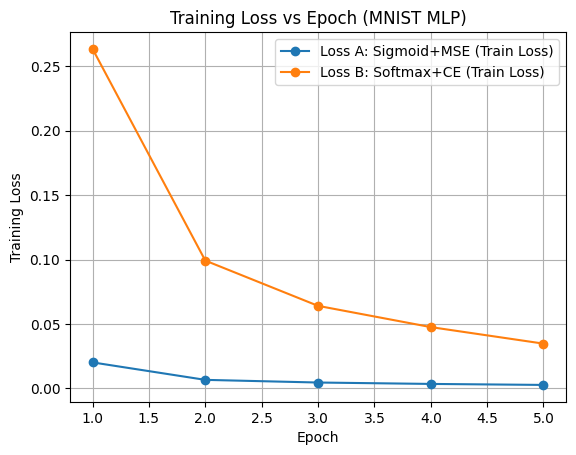

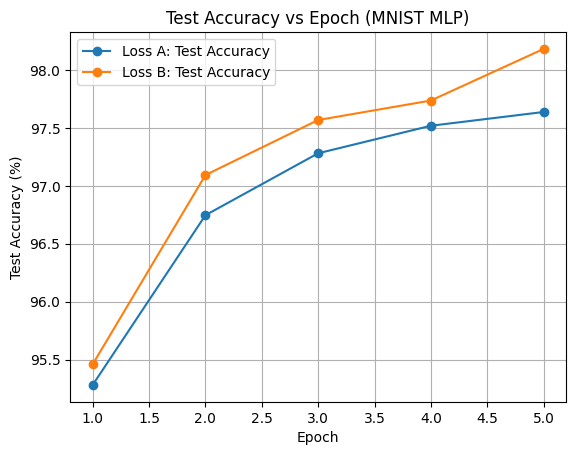

[INFO] Saved plots:
 - problem1_train_loss_overlay.png
 - problem1_test_acc_overlay.png


In [11]:
# ==========================================================
# Problem 1(a) - STEP 11: Plot Learning Curves (Overlay)
# ==========================================================

import matplotlib.pyplot as plt

epochs = list(range(1, len(hist_A["train_loss"]) + 1))

# 1) Plot Training Loss vs Epoch (Overlay)
plt.figure()
plt.plot(epochs, hist_A["train_loss"], marker="o", label="Loss A: Sigmoid+MSE (Train Loss)")
plt.plot(epochs, hist_B["train_loss"], marker="o", label="Loss B: Softmax+CE (Train Loss)")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch (MNIST MLP)")
plt.legend()
plt.grid(True)
plt.savefig("problem1_train_loss_overlay.png", dpi=200, bbox_inches="tight")
plt.show()

# 2) Plot Test Accuracy vs Epoch (Overlay)
plt.figure()
plt.plot(epochs, [a*100 for a in hist_A["test_acc"]], marker="o", label="Loss A: Test Accuracy")
plt.plot(epochs, [b*100 for b in hist_B["test_acc"]], marker="o", label="Loss B: Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs Epoch (MNIST MLP)")
plt.legend()
plt.grid(True)
plt.savefig("problem1_test_acc_overlay.png", dpi=200, bbox_inches="tight")
plt.show()

print("[INFO] Saved plots:")
print(" - problem1_train_loss_overlay.png")
print(" - problem1_test_acc_overlay.png")


### STEP 12: Time to Reach 90% Accuracy (Timing Analysis Table)

Timing Analysis: A table comparing total training time to reach 90% accuracy.

We will compute:

First epoch where test accuracy ≥ 90%

Total cumulative wall-clock time until that epoch

For:

Loss A (Sigmoid + MSE)

Loss B (Stable Softmax + CE)

In [12]:
# ==========================================================
# Problem 1(a) - STEP 12: Time to Reach 90% Accuracy
# ==========================================================

def time_to_reach_accuracy(history, threshold=0.90):
    """
    Returns:
      epoch_index (1-based)
      cumulative_time_sec
    """
    cumulative_time = 0.0

    for i in range(len(history["test_acc"])):
        cumulative_time += history["epoch_time_sec"][i]

        if history["test_acc"][i] >= threshold:
            return i + 1, cumulative_time  # epoch number (1-based)

    return None, None


epoch_A, time_A = time_to_reach_accuracy(hist_A, threshold=0.90)
epoch_B, time_B = time_to_reach_accuracy(hist_B, threshold=0.90)

print("[RESULT] Loss A reached 90% at epoch:", epoch_A)
print("[RESULT] Loss A time to 90%:", round(time_A, 2), "seconds")

print("[RESULT] Loss B reached 90% at epoch:", epoch_B)
print("[RESULT] Loss B time to 90%:", round(time_B, 2), "seconds")


[RESULT] Loss A reached 90% at epoch: 1
[RESULT] Loss A time to 90%: 11.83 seconds
[RESULT] Loss B reached 90% at epoch: 1
[RESULT] Loss B time to 90%: 13.45 seconds


### STEP 13 — Plot 10-class probability distribution

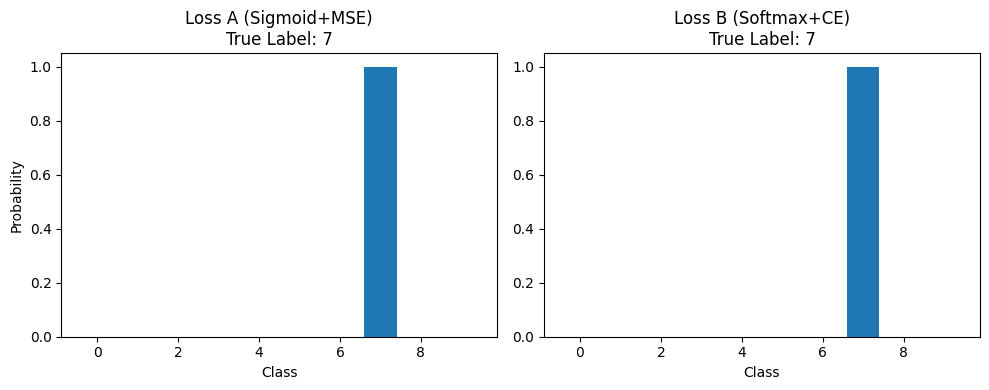

[INFO] Saved plot: problem1_confidence_comparison.png


In [13]:
# ==========================================================
# STEP 13: Prediction Confidence Comparison
# ==========================================================

import matplotlib.pyplot as plt
import torch.nn.functional as F

model_A.eval()
model_B.eval()

# Take one test image
x_test, y_test = next(iter(test_loader))
x_sample = x_test[0:1].to(device)
true_label = y_test[0].item()

with torch.no_grad():
    logits_A = model_A(x_sample)
    logits_B = model_B(x_sample)

    probs_A = torch.sigmoid(logits_A).cpu().numpy()[0]
    probs_B = F.softmax(logits_B, dim=1).cpu().numpy()[0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(range(10), probs_A)
plt.title(f"Loss A (Sigmoid+MSE)\nTrue Label: {true_label}")
plt.xlabel("Class")
plt.ylabel("Probability")

plt.subplot(1,2,2)
plt.bar(range(10), probs_B)
plt.title(f"Loss B (Softmax+CE)\nTrue Label: {true_label}")
plt.xlabel("Class")

plt.tight_layout()
plt.savefig("problem1_confidence_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

print("[INFO] Saved plot: problem1_confidence_comparison.png")
